In [1]:
# for local use
db_work_dir = '..'

In [8]:
import _mypath
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [3]:
# input
db_name = 'data_equalize'
db_path = os.path.join(db_work_dir, db_name)

# output
output_path = os.path.join('..', 'output', 'cnn_transformer')
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

model_path = os.path.join(output_path, 'model')
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)


In [4]:
batch_size_cnn = 32
batch_size_transformer = 32

image_size = 256
input_shape = (image_size, image_size, 1)

learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100

label_smoothing = 0.1
lam_recon = 10.
patience = 5
min_delta = 0.005
min_delta_fine_tuning = 0.0005

# data augmentation
scale = 1. / 255.
flip = "horizontal"
rotation_factor = 10. / 360.
zoom_height_factor = 0.2
zoom_width_factor = 0.2

# vit
patch_size = 1
transformer_layers = 4
num_heads = 8
projection_dim = 64
transformer_units_rate = [2, 1]
mlp_head_units = [1024, 256]  # Size of the dense layers of the final classifier


Data augmentation

In [5]:
augmentation = keras.Sequential(
    [
      layers.Rescaling(scale=scale),
      layers.RandomFlip(flip),
      layers.RandomRotation(rotation_factor),
      layers.RandomZoom(height_factor=zoom_height_factor, width_factor=zoom_width_factor),
    ],
    name='augmentation'
)

2023-01-30 19:31:10.017710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


cnn encoder

In [6]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout

encoder = keras.Sequential(
    [
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Flatten(),
    ],
    name='encoder'
)

decoder

In [9]:
decoder = keras.Sequential(
    [
      layers.Dense(1024, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(np.prod(input_shape), activation='sigmoid'),
      layers.Reshape(target_shape=input_shape),
    ],
    name='decoder'
)


In [10]:
classifier = keras.Sequential(
    [
      layers.Dense(1024, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(3, activation='softmax'),
    ],
    name='classifier'
)


In [11]:
# for producing graph plot only
inputs = layers.Input(shape=input_shape)
augmented = augmentation(inputs)
encoded = encoder(augmented)
decoded = decoder(encoded)
classified = classifier(encoded)

model_cnn_autoencoder = keras.Model(inputs=inputs, outputs=[classified, decoded])
model_augmented = keras.Model(inputs=inputs, outputs=augmented)
model_encoded = keras.Model(inputs=augmented, outputs=encoded)
model_decoded = keras.Model(inputs=augmented, outputs=decoded)
model_classified = keras.Model(inputs=encoded, outputs=classified)

model_pure_cnn = keras.Model(inputs=inputs, outputs=classified)


In [31]:
model_cnn_autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 augmentation (Sequential)      (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 encoder (Sequential)           (None, 4096)         296512      ['augmentation[0][0]']           
                                                                                                  
 classifier (Sequential)        (None, 3)            4458499     ['encoder[0][0]']            

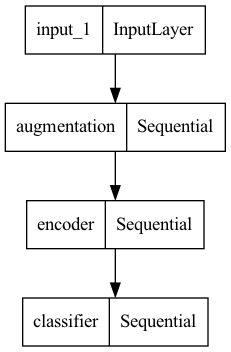

In [13]:
# for producing graph plot only

model_file_name = os.path.join(model_path, 'cnn_autoencoder.png')
plot_model(model_cnn_autoencoder, to_file=model_file_name)
model_file_name = os.path.join(model_path, 'cnn_autoencoder_expand.png')
plot_model(model_cnn_autoencoder, expand_nested=True, to_file=model_file_name)

model_file_name = os.path.join(model_path, 'augmentation.png')
plot_model(model_augmented, expand_nested=True, to_file=model_file_name)

model_file_name = os.path.join(model_path, 'cnn_autoencoder_encoder.png')
plot_model(model_encoded, expand_nested=True, to_file=model_file_name)

model_file_name = os.path.join(model_path, 'cnn_autoencoder_decoder.png')
plot_model(model_decoded, expand_nested=True, to_file=model_file_name)

model_file_name = os.path.join(model_path, 'cnn_autoencoder_classifier.png')
plot_model(model_classified, expand_nested=True, to_file=model_file_name)

model_file_name = os.path.join(model_path, 'pure_cnn.png')
plot_model(model_pure_cnn, to_file=model_file_name)


In [24]:
shared_encoder = keras.Sequential(name='shared_encoder')
for layer in encoder.layers[:-1]:
  shared_encoder.add(layer)

from myLayers.vision_transformer import add_vit
from myLayers.mlp import mlp

# inputs = layers.Input(shape=input_shape)
# augmented_transformer = augmentation(inputs)
shared_encoded = shared_encoder(augmented)

transformer_layers = 1
features = add_vit(shared_encoded,
            patch_size=patch_size,
            input_image_size=shared_encoded.shape[1],
            transformer_layers=transformer_layers,
            num_heads=num_heads,
            projection_dim=projection_dim,
            transformer_units_rate=transformer_units_rate,
            mlp_head_units=mlp_head_units)
            
# Classify outputs.
softmax = layers.Dense(3, activation='softmax', kernel_initializer='random_normal')(features)

# Create the Keras model
model_cnn_transformer = keras.Model(inputs=inputs, outputs=softmax)

model_shared_encoded = keras.Model(inputs=augmented, outputs=shared_encoded)
model_transformer = keras.Model(inputs=shared_encoded, outputs=features)
model_softmax = keras.Model(inputs=features, outputs=softmax)


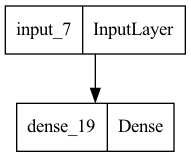

In [20]:
model_file_name = os.path.join(model_path, 'cnn_transformer.png')
plot_model(model_cnn_transformer, to_file=model_file_name)

model_file_name = os.path.join(model_path, 'cnn_transformer_encoder.png')
plot_model(model_shared_encoded, expand_nested=True, to_file=model_file_name)

model_file_name = os.path.join(model_path, 'cnn_transformer_transformer.png')
plot_model(model_transformer, expand_nested=True, to_file=model_file_name)

model_file_name = os.path.join(model_path, 'cnn_transformer_softmax.png')
plot_model(model_softmax, expand_nested=True, to_file=model_file_name)


In [25]:
model_transformer.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 8, 8, 64)]   0           []                               
                                                                                                  
 patches_1 (Patches)            (None, None, 64)     0           ['input_9[0][0]']                
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 64, 64)      8256        ['patches_1[1][0]']              
                                                                                                  
 layer_normalization_9 (LayerNo  (None, 64, 64)      128         ['patch_encoder_1[1][0]']        
 rmalization)                                                                              